In [23]:
# !pip install python-snap7==0.5
# va en version 1.1
import snap7.client as c
from snap7.util import * #set_int   set_bool
from snap7.snap7types import * # areas
import time
# !pip install keyboard 
import keyboard  # using module keyboard
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Excitación del módulo  multivariable SIEMENS del PCJIC

En el laboratorio de automática del Politécnico Colombiano Jaime Isaza Cadavid se encuentra un módulo multivariable que está controlado con un PLC  SIEMENS. Por esta razón, se utiliza el módulo `SNAP7` para interactuar con el PLC desde el notebook.

Para instalar `SNAP7`:
- Use la instrucción 
~~~
!pip install python-snap7==0.5
~~~

- Descargue la librería completa de [https://sourceforge.net/projects/snap7/files/1.2.1/](https://sourceforge.net/projects/snap7/files/1.2.1/)

- Copie `snap7.dll` y `snap7.lib` a su carpeta `System32`.



## 1. Establezca conexión con el PLC.

El PLC tiene configurada la dirección IP **192.168.0.1**. Este funcionará como un servidor al cuál debe conectar su PC configurándole una dirección estática dentro de la subred del PLC.  Su dirección puede ser **192.168.0.2**, por ejemplo. Una vez su equipo haya establecido comunicación con el PLC, establezca conexión desde el notebook con las siguientes instrucciones.

In [24]:
#Conexión con el PLC
plc = c.Client()
IP_PLC = '192.168.0.1'

In [25]:
try:
    plc.connect(IP_PLC,0,1)
    print("Conectado")
except:
    print("Algo no funcionó")

Conectado


## 2. Identifique actuadores y sensores.

Con `SNAP7` puede manipular los actuadores del sistema y capturar los datos de los sensores. Se han construido algunas funciones para facilitar la interacción con el PLC. 

Tenga en cuenta la siguiente información, que le orientará en cómo se ha conectado el sistema al PLC.

|Elemento   |  Punto  |
|-----------|---------|
| Presión 	|    IW96 |
| Flujo		|    IW98 |
| Nivel		|   IW100 |
| Run Bomba	|    Q0.5 |
| Bomba		|    QW80 |
| Válvula H20 |  QW96 |

In [26]:
#ESCRIBIR SALIDA BOOLEANA
def escr_sal_bool(byte, bit, valor):
    lectura = plc.ab_read(byte, bit)
    set_bool(lectura, byte, bit, valor)
    plc.ab_write(0, lectura)
#escr_sal_bool(0,1,1)

#ESCRIBIR SALIDA ENTERO
def escr_sal_ent(byte,valor):
    lectura = plc.read_area(areas['PA'], 0, byte, 2) #PA: salidas, 0: bloque de datos, dirección, # bytes.
    # print(lectura)
    set_int(lectura, 0, valor)  # se da formato al valor deseado, en este caso entero
    plc.write_area(areas['PA'], 0, byte, lectura)  # Escribe en la dirección definida
#escr_sal_ent(90,9000)

#LEER MARCA ENTERA
def leer_ent_ent(byte):
    leer = plc.read_area(areas['PE'],0,byte,2) #PE: entradas, 0: bloque de datos, dirección, # bytes.
    leer_ent = get_int(leer,0) #Comando get_int(_bytearray, byte_index)
    return leer_ent

def AbrirValvulaQW96(valvulap):
    # Abre la valvula en QW96 a un porcentaje determinado
    valvula = ((7800 / 71.5) * (valvulap - 7.4)) + 6200
    escr_sal_ent(96,valvula)
    

def BombaQW80(motobombaHz):
    #Poner bomba en 60Hz salida QW80
    motobomba = motobombaHz * (22118 / 60) + 5530
    escr_sal_ent(80,motobomba)

def leerNivelPLCIW100():
    nivelplc = leer_ent_ent(100)
    nivelcm = ((60 / 15105) * (nivelplc - 10125)) + 20
    # print(nivelplc, nivelcm)
    return nivelcm

def leerPresionPLCIW96():
    presionplc = leer_ent_ent(96)
    # 0.64 5679
    # 0.4  5623
    mp = (0.64-0.4)/(5679-5623)
    presion =  mp* presionplc - mp *5623+0.4
    # print(presionplc, presion)
    return presion


def leerFlujoPLCIW98():
    flujoplc = leer_ent_ent(98)
    # 4.67 8773 
    # 16.52  16957 
    mf = (4.67-16.52)/(8773-16957)
    flujo =  mf* flujoplc - mf *16957+16.52
    # print(flujoplc, flujo)
    return flujo

def leerNada():
    return np.random.rand(1)[0]

## 3. Inicie el experimento.

El módulo multivariable tiene:
- 2 actuadores:
    - Motobomba
    - Válvula
- 3 sensores:
    - Flujo
    - Presión
    - Nivel

3.1 Escoja una variable como salida y un actuador para su experimento.

3.2 Ponga un punto de operación para el otro actuador.

**Establecer un punto para la bomba**
~~~
BombaQW80(60)
~~~

**Establecer un punto para la válvula**
~~~
AbrirValvulaQW96(100)
~~~

In [27]:
escr_sal_bool(0,5,1)#Habilitar RUN motobomba
# Complete para establecer un punto de operación
BombaQW80(30)
AbrirValvulaQW96(50)

In [30]:
leerPresionPLCIW96(),leerNivelPLCIW100(),leerFlujoPLCIW98()

(2.0542857142857165, 6.427010923535253, 9.096374633431086)

## 5. Defina la entrada del sistema

Esta vez se configura una entrada en forma de un escalón.

\begin{equation}
U(t) = \begin{cases} V_0 & \forall t<t_0 \\  V_f &  \forall t > t_0 \end{cases}
\end{equation}

Defina:
- Tiempo de muestreo $t_m$
- Duración para el experimento $t_f$
- Valor inicial para el actuador $V_0$
- Valor final para el actuador $V_f$

**Lista de tiempos $t$**

In [31]:
tm = 0.5
tf = 300
t = np.linspace(0.0 ,tf, round(tf/tm) + 1)
t

array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
        18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,
        22.5,  23. ,  23.5,  24. ,  24.5,  25. ,  25.5,  26. ,  26.5,
        27. ,  27.5,  28. ,  28.5,  29. ,  29.5,  30. ,  30.5,  31. ,
        31.5,  32. ,  32.5,  33. ,  33.5,  34. ,  34.5,  35. ,  35.5,
        36. ,  36.5,  37. ,  37.5,  38. ,  38.5,  39. ,  39.5,  40. ,
        40.5,  41. ,  41.5,  42. ,  42.5,  43. ,  43.5,  44. ,  44.5,
        45. ,  45.5,  46. ,  46.5,  47. ,  47.5,  48. ,  48.5,  49. ,
        49.5,  50. ,  50.5,  51. ,  51.5,  52. ,  52.5,  53. ,  53.5,
        54. ,  54.5,  55. ,  55.5,  56. ,  56.5,  57. ,  57.5,  58. ,
        58.5,  59. ,  59.5,  60. ,  60.5,  61. ,  61.5,  62. ,  62.5,
        63. ,  63.5,

**Señal de entrada $U(t)$**

In [32]:
t0 = 30
v0 = 50
vf = 80
U = np.where(t>=t0,vf,v0)
U

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 80, 80, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
       80, 80, 80, 80, 80

**Gráfica de la señal**

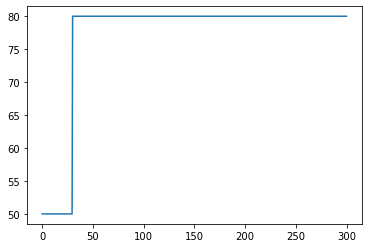

In [34]:
plt.plot(t,U)

## 6. Realice el experimento y guarde

Entregue los valores definidos para $U(t)$ en el actuador cada $t_m$ segundos, lea el sensor apropiado para su caso y guarde la información necesaria. Para esto puede crear un archivo `csv` a partir de un **dataframe**.

Para leer los sensores se han definido las siguientes funciones:

~~~
leerNivelPLCIW100()
leerPresionPLCIW96()
leerFlujoPLCIW98()
~~~

In [35]:
Y = []
print('Para abortar el experimento presione ESPACIO')
abortado = False
for idt,ti in enumerate(t):
    Entrada = U[idt]
    # Poner el valor en el actuador
    AbrirValvulaQW96(Entrada)
    #BombaQW80(Entrada)
    Y.append(leerNivelPLCIW100())
    if keyboard.is_pressed(' '):
        print('Abortando el experimento a los ' + 
              str(ti) +' segundos')
        abortado = True
        escr_sal_bool(0,5,0)
        BombaQW80(5)
        AbrirValvulaQW96(0)
        
        break
    time.sleep(tm)
    
if abortado:
    Y = Y + [np.nan]*(len(U)-len(Y))
d = {'Tiempo': t, 'Entrada': U, 'Salida': Y}

df = pd.DataFrame(data=d)
df.head()
escr_sal_bool(0,5,0)
AbrirValvulaQW96(0)


Para abortar el experimento presione ESPACIO


C:\Users\Usuario\.conda\envs\SistDin\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Usuario\.conda\envs\SistDin\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Usuario\.conda\envs\SistDin\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


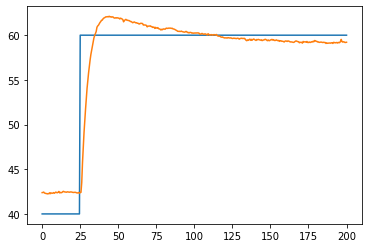

In [18]:
# Gráfica de entrada y salida
plt.plot(df["Tiempo"],df["Entrada"],
         df["Tiempo"],10*df["Salida"])

In [36]:
# Guarda datos
archivo = "Datos/m_laura_cuartas.csv"
df.to_csv(archivo, index=False)